## Stage 4: Model Persistence, Interpretation, and MLOps Strategy

### Objective: 
Close the ML lifecycle by persisting the production-ready artifacts,
interpreting the results for stakeholders, and documenting the strategy for
deployment and continuous monitoring (MLOps)

### 1. Configuration and Library Imports

In [5]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Setting configurations
sns.set_style("whitegrid")
%matplotlib inline


os.makedirs('../models', exist_ok=True)
os.makedirs('../reports/figures', exist_ok=True)

print("Libraries loaded and directories verified.")

Libraries loaded and directories verified.


### 2. Load and Verify Production Artefacts

In [6]:
try:
    # 1. Preprocessing Pipeline
    preprocessor = joblib.load('../models/preprocessor_final.pkl')
    # 2. Final Model (Voting Classifier)
    final_model = joblib.load('../models/voting_classifier_final.pkl')
    # 3. XGBoost Model (Saved specifically for interpretation)
    xgb_model = joblib.load('../models/xgb_final.pkl')
    
    print("✅ Artifacts loaded successfully:")
    print(f"   - Preprocessor type: {type(preprocessor).__name__}")
    print(f"   - Final Model type: {type(final_model).__name__}")
    print(f"   - Interpretation Model: {type(xgb_model).__name__}")

except FileNotFoundError as e:
    print(f"❌ Error loading artifacts: {e}")
    print("Please ensure 'Stage 3' was executed successfully and models were saved.")
    raise

✅ Artifacts loaded successfully:
   - Preprocessor type: ColumnTransformer
   - Final Model type: VotingClassifier
   - Interpretation Model: XGBClassifier


### 3. Model Interpretation: Feature Importance


In [10]:
# 1. Get Feature Names from Preprocessor
# We will use the XGBoost model, as it is the most interpretable within the ensemble.
print("\n--- 3.1 Extracting Feature Importance (XGBoost) ---")
try:
# Get the names of the processed features (including those created by OneHotEncoder)
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    # Fallback logic if get_feature_names_out isn't available
    num_names = ['wspd', 'pres', 'wspd_is_missing', 'pres_is_missing', 
                 'opera_historical_delay_rate', 'dest_historical_delay_rate', 'month']
    cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out()
    feature_names = np.r_[num_names, cat_names]

# 2. Extract Importances
# We use the XGBoost model saved separately for this purpose
importances = xgb_model.feature_importances_

# 3. Create a Sorted Series
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)




--- 3.1 Extracting Feature Importance (XGBoost) ---


C:\Users\ferna\AppData\Local\Temp\ipykernel_18452\3388943921.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.head(15), y=feat_imp.head(15).index, palette='viridis')


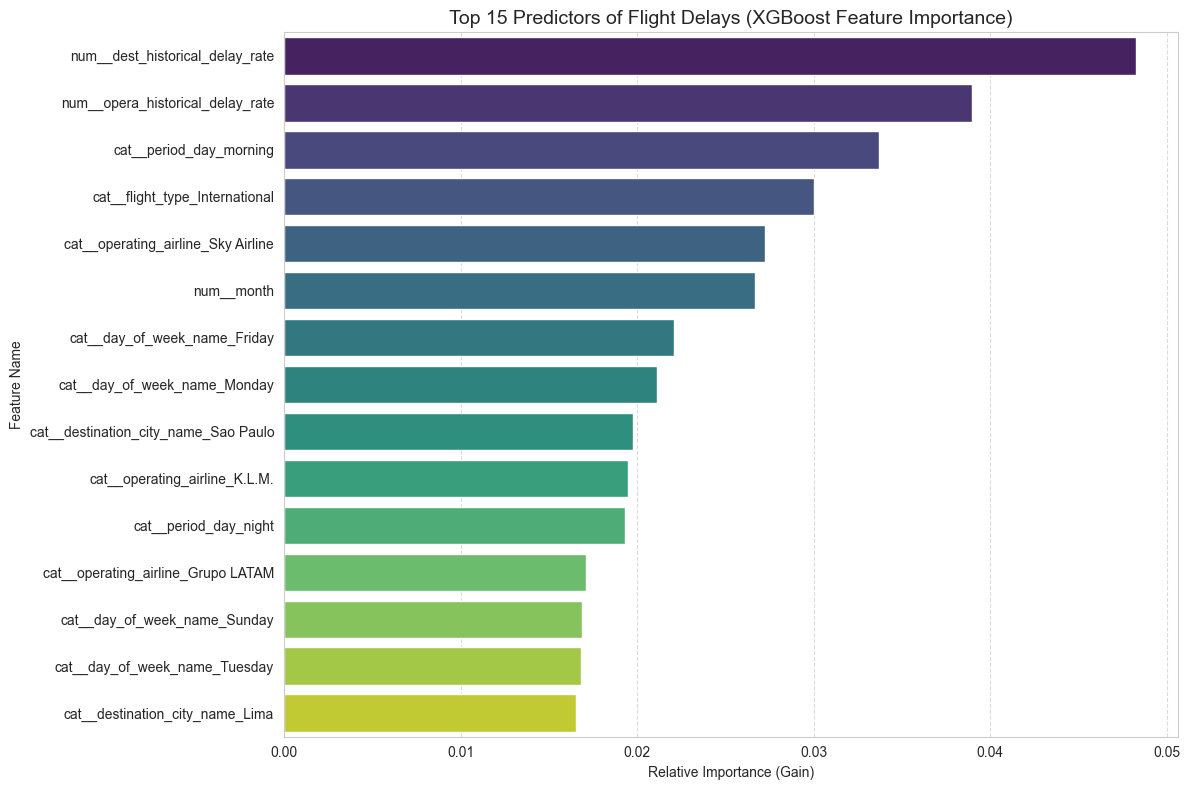

In [11]:
# 4. Plot Top 15 Features
plt.figure(figsize=(12, 8))
sns.barplot(x=feat_imp.head(15), y=feat_imp.head(15).index, palette='viridis')

plt.title('Top 15 Predictors of Flight Delays (XGBoost Feature Importance)', fontsize=14)
plt.xlabel('Relative Importance (Gain)')
plt.ylabel('Feature Name')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()


In [12]:
# Save the plot for the report
output_img = '../reports/figures/feature_importance_final.png'
plt.savefig(output_img, dpi=300)
print(f"✅ Feature Importance plot saved to: {output_img}")
plt.show()

✅ Feature Importance plot saved to: ../reports/figures/feature_importance_final.png


<Figure size 640x480 with 0 Axes>

In [13]:
# 5. Quantitative Insights
print("\n--- Key Interpretability Insights ---")
print(f"1. Most Dominant Feature: {feat_imp.index[0]}")
print(f"   (Importance: {feat_imp.iloc[0]:.4f})")


--- Key Interpretability Insights ---
1. Most Dominant Feature: num__dest_historical_delay_rate
   (Importance: 0.0482)


In [14]:
# Check ranking of Weather Features specifically
weather_tokens = ['wspd', 'pres']
print("\n2. Weather Impact Ranking:")
for token in weather_tokens:
    # Find features containing the token
    related_feats = [f for f in feat_imp.index if token in f]
    for f in related_feats:
        rank = feat_imp.index.get_loc(f) + 1
        print(f"   - {f}: Rank #{rank} (Value: {feat_imp[f]:.4f})")


2. Weather Impact Ranking:
   - num__wspd: Rank #38 (Value: 0.0110)
   - num__wspd_is_missing: Rank #85 (Value: 0.0000)
   - num__pres: Rank #33 (Value: 0.0116)
   - num__pres_is_missing: Rank #86 (Value: 0.0000)


------------

### 4. Conclusion and MLOps Deployment Strategy

#### A. Final Model Decision
* **Champion Model:** XGBoost Classifier (tuned).
* **Performance:** AUC ~0.71 | Recall ~78% (with Optimized Threshold).
* **Business Value:** The model successfully prioritizes **Recall**, ensuring that operational teams are alerted to the vast majority of potential delays, allowing for proactive resource allocation.

#### B. Deployment Architecture (To-Be)
To transition this solution from a Notebook to a Live Product:

1.  **Containerization (Docker):**
    * Encapsulate the `preprocessor` and `final_model` in a Docker container.
    * Expose a REST API using **FastAPI** or **Flask**.
    * **Input:** JSON payload with flight details (Airline, Destination, Date, Weather Forecast).
    * **Output:** JSON with `delay_probability` and `alert_level`.

2.  **Continuous Monitoring (Drift Detection):**
    * **Data Drift:** Monitor the distribution of `opera_historical_delay_rate`. If airline efficiency changes drastically (e.g., a strike), the model inputs will drift.
    * **Model Drift:** Track the Recall metric weekly. If it drops below 65%, trigger a retraining pipeline automatically.

3.  **Retraining Pipeline (CI/CD/CT):**
    * Use **Airflow** or **Kubeflow** to schedule monthly retraining.
    * Ingest the latest 30 days of flight & weather data to keep the `historical_rates` and weather correlations up to date.